In [185]:
jake_classes = {
    1: "JAKE",
    2: "JAKE+BOOTS",
    3: "JETPACK"
}

obstacle_classes = {
    0: "BOOTS",
    1: "GREYTRAIN",
    2: "HIGHBARRIER1",
    3: "JUMP",
    4: "LOWBARRIER1",
    5: "LOWBARRIER2",
    6: "ORANGETRAIN",
    7: "PILLAR",
    8: "RAMP",
    9: "RAILS",
    10: "SIDEWALK",
    11: "YELLOWTRAIN"
}


In [192]:
import os, time
import numpy as np
from PIL import Image
from ultralytics import YOLO
from rfdetr import RFDETRBase
import torch
from PIL import Image
from IPython.display import display

class Forced:
    def __init__(
        self,
        jake_weights: str,
        obstacle_weights: str,
        image_extract: str,
        jump_thresh: int = 12,
        duck_thresh: int = 8,
    ):
        device = "mps" if torch.backends.mps.is_available() else "cpu"
        self.device    = device
        self.jake_model  = RFDETRBase(
            pretrain_weights=os.path.expanduser(jake_weights),
            num_classes=3
        )
        self.yolo_model  = YOLO(os.path.expanduser(obstacle_weights))
        self.image_path  = os.path.expanduser(image_extract)
        self.jump_thresh = jump_thresh
        self.duck_thresh = duck_thresh

    def jake_pred(self, j: int, i: int):
        img_pth = f"{self.image_path}{j}{i}.jpg"
        img     = Image.open(img_pth)
        dets    = self.jake_model.predict(img, threshold=0.5, device=self.device)[0]
        H, W    = img.size[1], img.size[0]
        mask    = np.zeros((H, W), dtype=bool)
        x1, y1, x2, y2 = dets.xyxy[0].astype(int)
        mask[y1:y2, x1:x2] = True
        return dets, mask         
        """Returns (DETR detection, boolean_mask_HxW)"""

    def obstacles_pred(self, j: int, i: int):
        img_pth = f"{self.image_path}{j}{i}.jpg"
        file     = Image.open(img_pth)
        W_orig, H_orig = file.size

        res       = self.yolo_model.predict(source=img_pth,
                                            task="segment",
                                            conf=0.30,
                                            iou=0.45)[0]
        raw_masks = res.masks.data.cpu().numpy()   # shape: (N, H_net, W_net)
        cls_ids   = res.boxes.cls.cpu().numpy().astype(int)
        confs     = res.boxes.conf.cpu().numpy()

        # 3) resize each mask up to the original frame size
        up_masks = []
        for m in raw_masks:
            # m is float array of 0.0/1.0
            m8 = (m * 255).astype(np.uint8)
            m_rs = cv2.resize(m8,
                              (W_orig, H_orig),
                              interpolation=cv2.INTER_NEAREST)
            up_masks.append(m_rs.astype(bool))
        masks = np.stack(up_masks, axis=0)         # (N, H_orig, W_orig)

        img = Image.open(img_pth)
        display(img)

        return masks, cls_ids, confs
        """
        Returns
          masks: np.ndarray of shape (N, H_orig, W_orig) dtype=bool
          cls_ids: np.ndarray of shape (N,) dtype=int
          confs:   np.ndarray of shape (N,) dtype=float
        """







    
    @staticmethod
    def overlap_area(m1: np.ndarray, m2: np.ndarray) -> int:
        return int(np.logical_and(m1, m2).sum())

    def compute_overlaps(self, j: int, i: int):
        start = time.time()
        _, jmask          = self.jake_pred(j, i)
        omasks, cls_ids, confs = self.obstacles_pred(j, i)

        overlaps = []
        for idx, (mask, cid, conf) in enumerate(zip(omasks, cls_ids, confs)):
            area = self.overlap_area(jmask, mask)
            overlaps.append((idx, int(cid), float(conf), area))
        end = time.time()
        print(f"Overlap calculation time: {elapsed:.3f} seconds")

        return overlaps


Loading pretrain weights

image 1/1 /Users/marcus/SubwaySurfers/train_screenshots/frame_0011.jpg: 864x1504 2 GREYTRAINs, 1 RAMP, 3 Railss, 1 YELLOWTRAIN, 313.3ms
Speed: 10.4ms preprocess, 313.3ms inference, 13.9ms postprocess per image at shape (1, 3, 864, 1504)


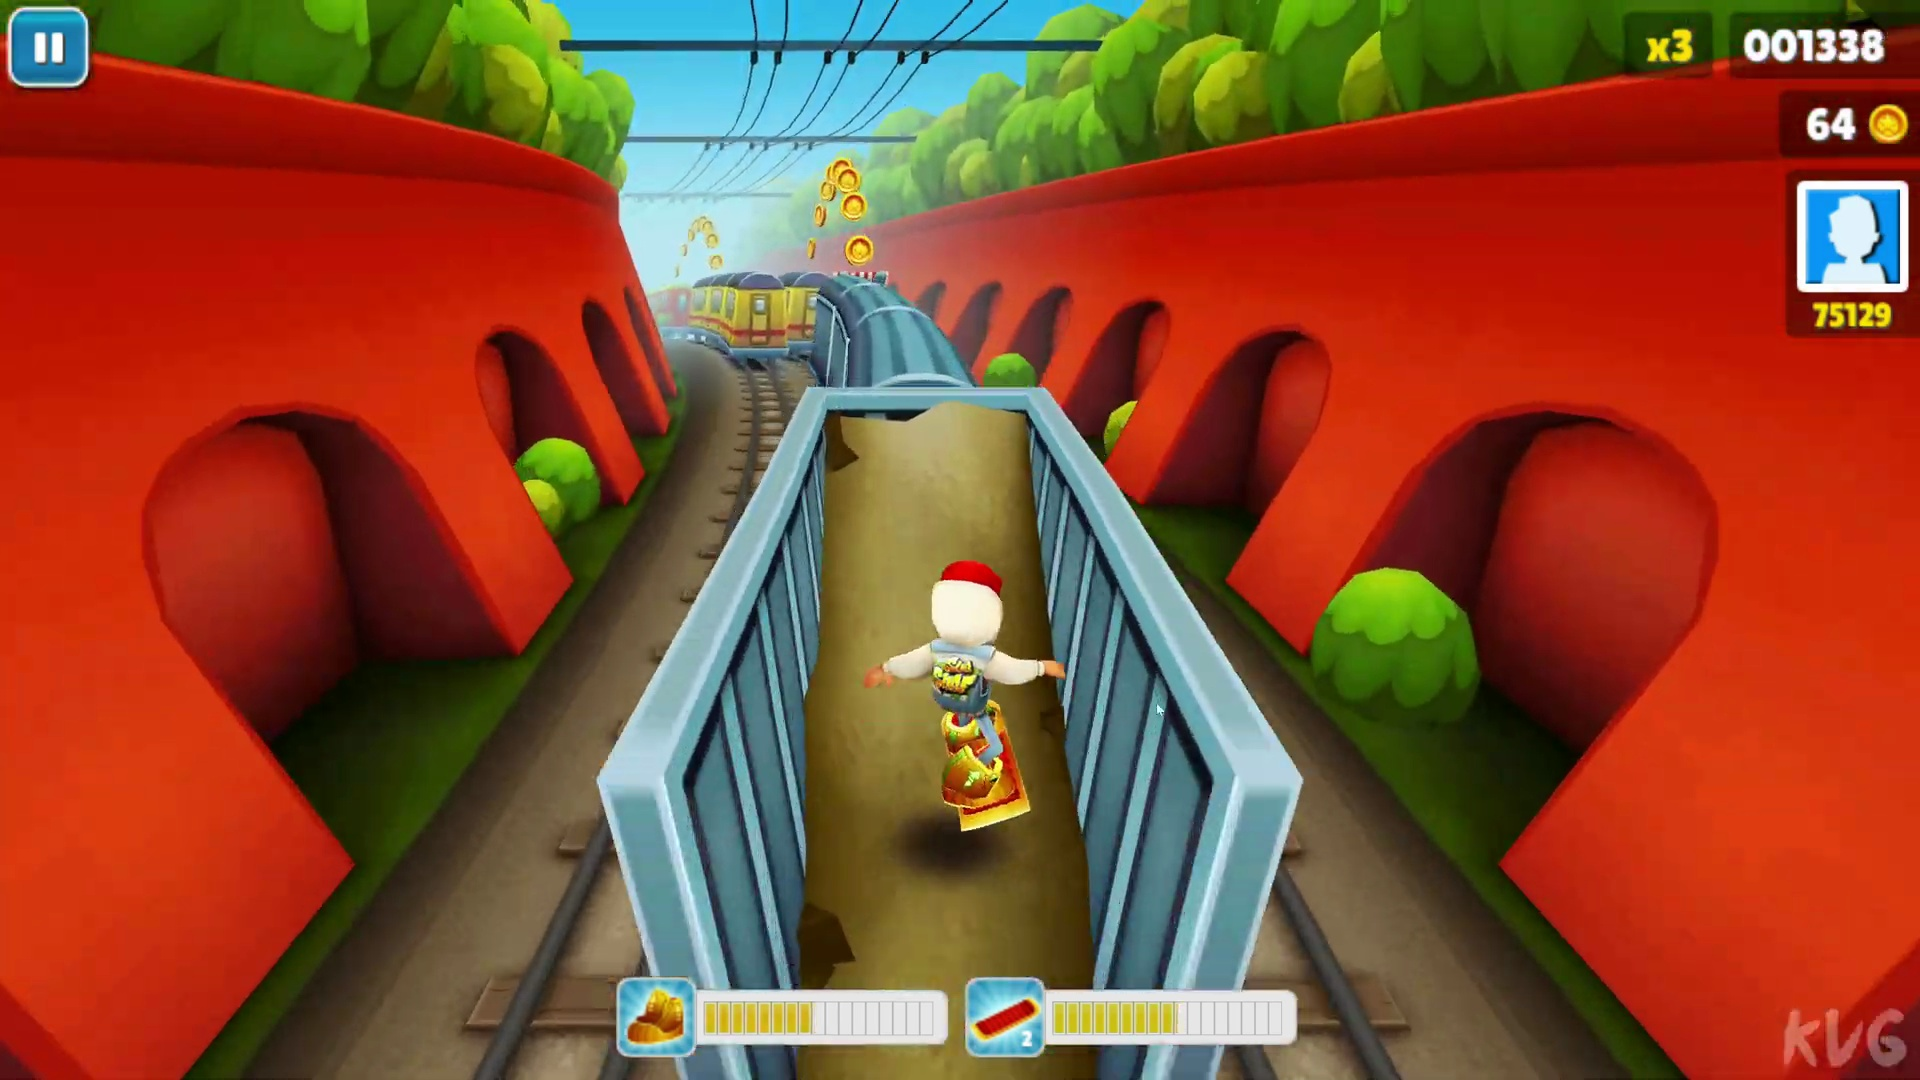

Overlap calculation time: 2.288 seconds
mask #0 (class 8 = RAMP, conf 0.88) overlaps Jake by 62916 px
mask #1 (class 9 = RAILS, conf 0.75) overlaps Jake by 0 px
mask #2 (class 11 = YELLOWTRAIN, conf 0.73) overlaps Jake by 0 px
mask #3 (class 1 = GREYTRAIN, conf 0.72) overlaps Jake by 0 px
mask #4 (class 9 = RAILS, conf 0.64) overlaps Jake by 0 px
mask #5 (class 9 = RAILS, conf 0.60) overlaps Jake by 0 px
mask #6 (class 1 = GREYTRAIN, conf 0.44) overlaps Jake by 0 px
Elapsed time: 2.432 seconds


In [193]:
#Testing block
import time

start = time.time()
f = Forced(
  jake_weights="~/downloads/weightsjake.pt",
  obstacle_weights="~/models/jakes-loped/jakes-finder-mk1/1/weights.pt",
  image_extract="~/SubwaySurfers/train_screenshots/frame_00",
)

overlaps = f.compute_overlaps(j=1, i=1)
for idx, cid, conf, area in overlaps:
    print(f"mask #{idx} (class {cid} = {obstacle_classes[cid]}, conf {conf:.2f}) overlaps Jake by {area} px")
end = time.time()

elapsed = end - start
print(f"Elapsed time: {elapsed:.3f} seconds")
